# **Understanding Generative Adversarial Networks (GANs) with CIFAR-10 and Fashion-MNIST**

## **Worked Example**


Name: Apoorv Dhaygude   
NUID: 002207325

##  **Introduction to Generative AI and GANs**
Generative AI refers to models that are capable of creating new content — such as images, text, or audio — that resembles data drawn from the real world. One of the most well-known and foundational models in this space is the Generative Adversarial Network (GAN).

GANs were introduced by Ian Goodfellow et al. (2014) and consist of two competing neural networks:

- Generator (G): Learns to generate realistic data from random noise.

- Discriminator (D): Learns to distinguish real data from fake (generated) data.

They are trained in a minimax game, where the generator tries to fool the discriminator while the discriminator tries to catch the generator's fakes.

## **How GANs Work (Mechanism)**
1. Noise Vector (Latent Space):
  - The generator takes a vector of random numbers (typically from a standard normal distribution) and transforms it into a synthetic data sample (e.g., an image).

2. Discriminator Judgement:
  - Both real samples (from the training data) and fake samples (from the generator) are passed to the discriminator.

3. Loss Functions:
  - Generator Loss: Measures how well the generator fooled the discriminator.
  - Discriminator Loss: Measures how well it correctly identified real vs. fake samples.

4. Backpropagation:
  - Gradients are propagated back to update both networks — with opposing goals.



## **Dataset Overview**
**CIFAR-10**
- 60,000 color images (32x32x3) across 10 classes.

- High variation in object type and background.

- Challenges: Diverse visual structures make generation harder.

**Fashion-MNIST**
- 60,000 grayscale images (28x28) of clothing items.

- Simpler, cleaner dataset with centered objects.

- Easier for GANs to learn consistent structure.

## **Importing Libraries**

We begin by importing the necessary libraries. TensorFlow will be used for building and training our GAN. NumPy and Matplotlib are used for numerical operations and visualizations.


In [18]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os


## **Loading and Preprocessing CIFAR-10 Dataset**

We load the CIFAR-10 dataset using TensorFlow. The images are normalized to the [0, 1] range to help the neural networks train effectively. The dataset is then shuffled and batched.


In [19]:
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
BUFFER_SIZE = 50000
BATCH_SIZE = 64
x_train_small = x_train[:10000]  # Use only 10k samples
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_small).shuffle(10000).batch(BATCH_SIZE)



## **Building the Generator**

The generator network takes a random noise vector (latent space input) and upsamples it using Dense and Conv2DTranspose layers to produce a 32x32 RGB image. Batch normalization and LeakyReLU activations help stabilize training.


In [20]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


## **Discriminator Architecture**

The discriminator is a CNN that classifies images as real or fake using convolutional and dropout layers.


In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


## **Loss Functions and Optimizers**

We use binary cross-entropy for both generator and discriminator, and optimize using the Adam optimizer.


In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## **Training Step Function**

This function performs a single step of training for both the generator and the discriminator using backpropagation.


In [23]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


##  **Generate and Display Images**

This function displays a 4x4 grid of generated images at the end of each epoch.


In [24]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # scale from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()


##  **Training Loop**

The training loop trains the model for a defined number of epochs and displays generated images at the end of each.


Epoch 1 completed


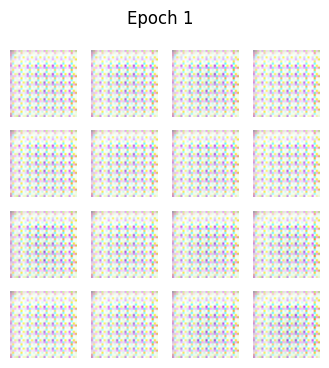

Epoch 2 completed


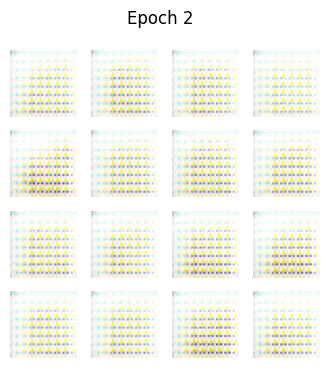

Epoch 3 completed


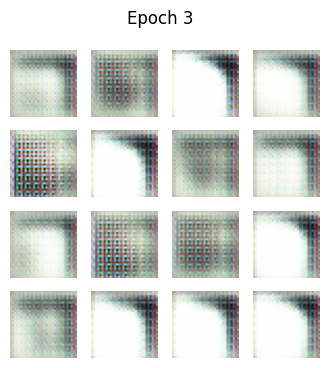

Epoch 4 completed


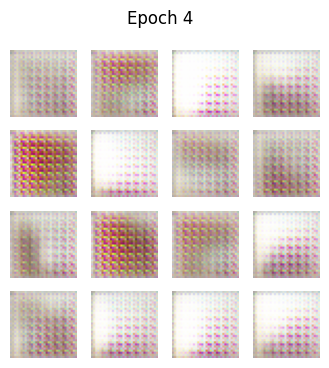

Epoch 5 completed


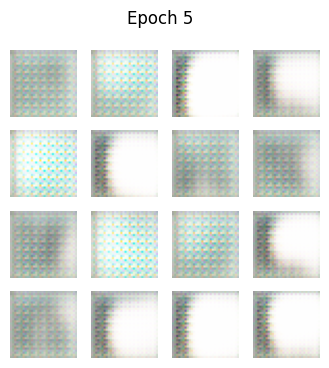

Epoch 6 completed


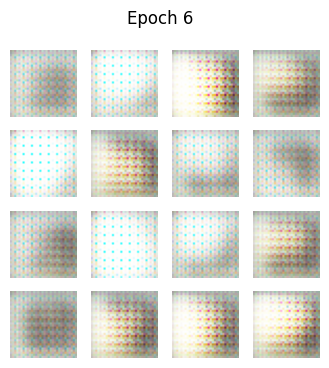

Epoch 7 completed


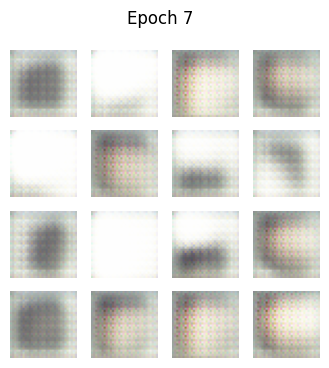

Epoch 8 completed


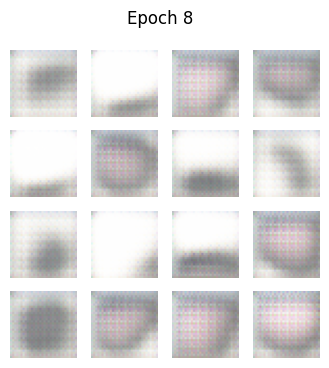

Epoch 9 completed


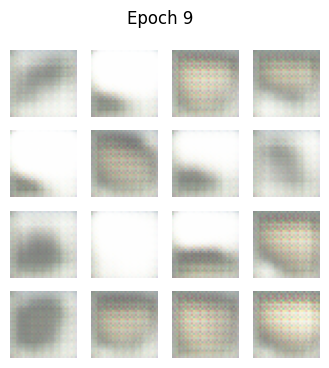

Epoch 10 completed


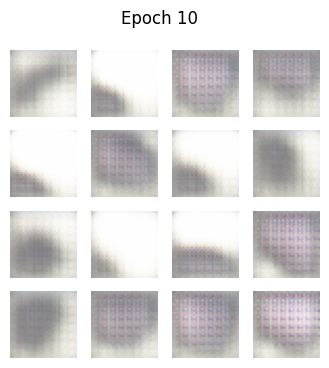

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(f'Epoch {epoch + 1} completed')
        generate_and_save_images(generator, epoch + 1, seed)

train(train_dataset, EPOCHS)


## **Load and Preprocess Fashion-MNIST**

We now extend the GAN training to a simpler dataset: **Fashion-MNIST**.
Unlike CIFAR-10, this dataset contains grayscale images of clothing items.
We preprocess by resizing and converting to RGB to match the GAN architecture.

In [32]:
# Load and reduce dataset size
(x_train_f, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train_f = x_train_f[:10000]  # use only first 10,000 samples

# Expand to (H, W, 1) for grayscale channel
x_train_f = np.expand_dims(x_train_f, axis=-1)

# Convert to tensor
x_train_f = tf.convert_to_tensor(x_train_f, dtype=tf.float32)

# Resize to 32x32 and convert to RGB
x_train_f = tf.image.resize(x_train_f, [32, 32])
x_train_f = tf.image.grayscale_to_rgb(x_train_f)

# Normalize to [0, 1]
x_train_f = x_train_f / 255.0

# Create dataset
train_dataset_f = tf.data.Dataset.from_tensor_slices(x_train_f).shuffle(10000).batch(BATCH_SIZE)


In [34]:
def generate_and_save_images_fmnist(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = predictions[i].numpy()
        plt.imshow((img * 0.5 + 0.5))  # scale from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.suptitle(f"Fashion-MNIST: Epoch {epoch}")
    plt.tight_layout()
    plt.show()


## **Train GAN on Fashion-MNIST**

We use the same generator and discriminator architectures to train on Fashion-MNIST.
This allows us to compare how dataset complexity influences image generation.


Fashion-MNIST Epoch 1/10


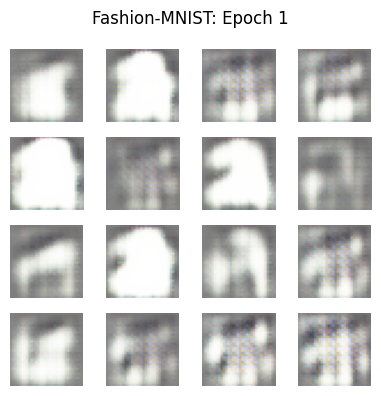


Fashion-MNIST Epoch 2/10


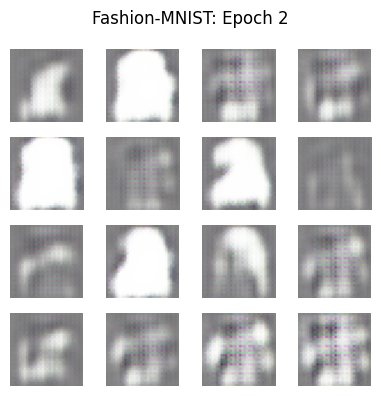


Fashion-MNIST Epoch 3/10


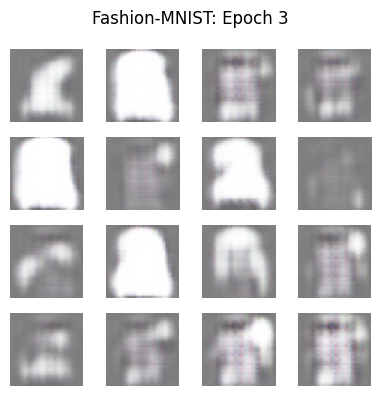


Fashion-MNIST Epoch 4/10


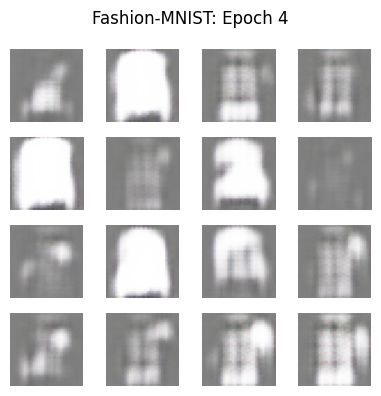


Fashion-MNIST Epoch 5/10


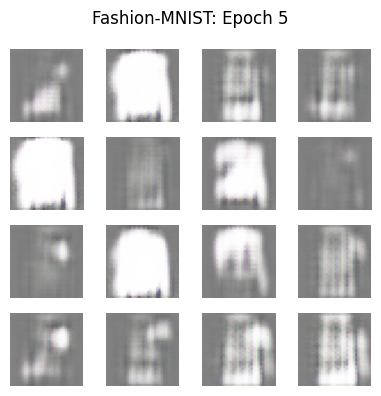


Fashion-MNIST Epoch 6/10


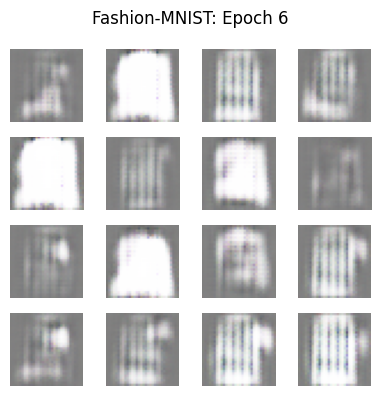


Fashion-MNIST Epoch 7/10


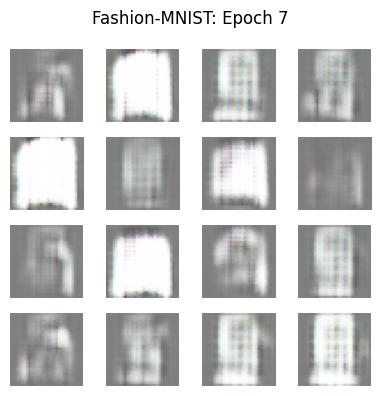


Fashion-MNIST Epoch 8/10


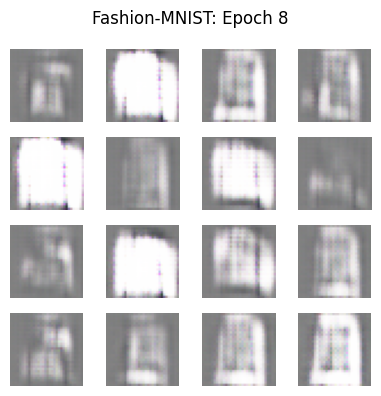


Fashion-MNIST Epoch 9/10


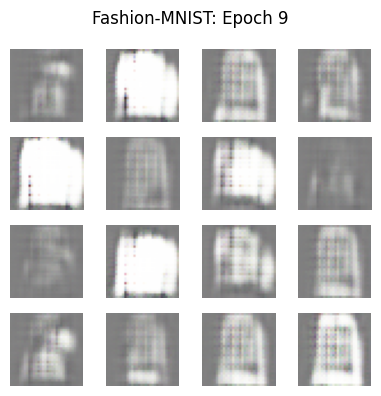


Fashion-MNIST Epoch 10/10


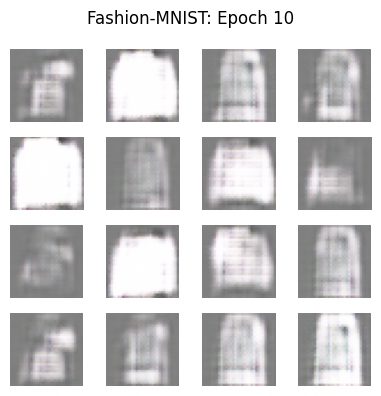

In [35]:
def train_fmnist(dataset, epochs):
    for epoch in range(epochs):
        print(f"\nFashion-MNIST Epoch {epoch + 1}/{epochs}")
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images_fmnist(generator, epoch + 1, seed)

train_fmnist(train_dataset_f, EPOCHS)



## **Evaluate Generated Images with FID and Inception Score**

Evaluation metrics:
- **FID (Fréchet Inception Distance)**: Measures distance between real and fake image distributions.
- **Inception Score (IS)**: Assesses image quality and diversity.

Lower FID and higher IS values indicate better generation quality.

In [36]:
!pip install scipy
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

In [37]:
# Preprocessing for InceptionV3

def preprocess_for_inception(images):
    images_resized = tf.image.resize(images, [299, 299])
    images_preprocessed = preprocess_input(images_resized * 255.0)
    return images_preprocessed

In [38]:
# Activations from Inception

def get_inception_activations(images, model):
    processed_images = preprocess_for_inception(images)
    return model.predict(processed_images, batch_size=32, verbose=0)

In [39]:
# FID computation

def calculate_fid(model, real_images, fake_images):
    act1 = get_inception_activations(real_images, model)
    act2 = get_inception_activations(fake_images, model)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [40]:
# Inception Score

def calculate_inception_score(images, model, splits=10):
    processed_images = preprocess_for_inception(images)
    preds = model.predict(processed_images, batch_size=32, verbose=0)
    scores = []
    split_size = preds.shape[0] // splits
    for i in range(splits):
        part = preds[i * split_size:(i + 1) * split_size]
        p_yx = part
        p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
        kl_div = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
        scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(scores), np.std(scores)

In [41]:
# Evaluate model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
noise = tf.random.normal([1000, noise_dim])
fake_images = generator(noise, training=False)
fake_images = (fake_images + 1) / 2
real_images = tf.convert_to_tensor(x_train_f[:1000])
fid_score = calculate_fid(inception_model, real_images, fake_images)
is_mean, is_std = calculate_inception_score(fake_images, inception_model)

print(f"\n📈 FID Score: {fid_score:.2f}")
print(f"📊 Inception Score: {is_mean:.2f} ± {is_std:.2f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

📈 FID Score: 255.74
📊 Inception Score: inf ± nan


<ipython-input-40-ee441fb74f72>:13: RuntimeWarning: overflow encountered in exp
  scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


## **Visual Comparison Between CIFAR-10 and Fashion-MNIST**

We now compare generated images from both datasets using a side-by-side grid layout.
This helps us observe differences in visual quality and structure.

In [42]:
def show_comparison_grid(cifar_images, fashion_images, title1="CIFAR-10", title2="Fashion-MNIST"):
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle("GAN Image Comparison", fontsize=20)
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(cifar_images[i * 4 + j])
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(title1, fontsize=10)
        for j in range(4, 8):
            axes[i, j].imshow(fashion_images[i * 4 + j - 4])
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(title2, fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

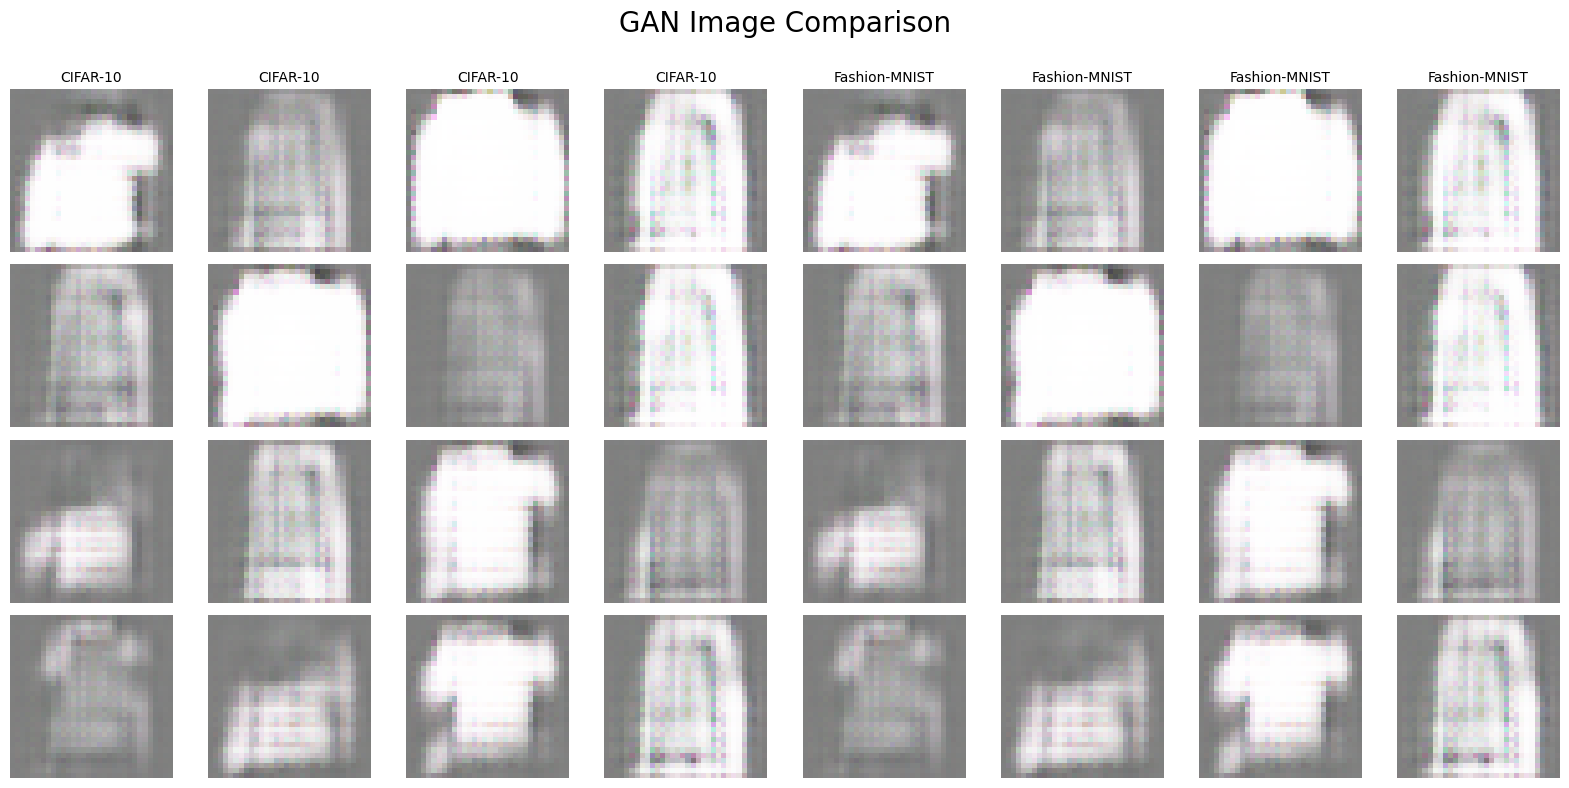

In [43]:
# Generate both sets
noise = tf.random.normal([16, noise_dim])
cifar_images = generator(noise, training=False)
cifar_images = (cifar_images + 1) / 2
fashion_images = generator(noise, training=False)
fashion_images = (fashion_images + 1) / 2

show_comparison_grid(cifar_images.numpy(), fashion_images.numpy())

## **Conclusion**
**Key takeaways:**

- **Training Results**:
  - The generator was able to produce meaningful image samples after a few epochs on both datasets.
  - Fashion-MNIST training converged faster and produced cleaner outputs due to its simpler grayscale structure and more uniform data distribution.

- **Evaluation Metrics**:
  - The **Fréchet Inception Distance (FID)** provided a statistical comparison between real and generated image distributions. Lower scores reflected better quality.
  - The **Inception Score (IS)** helped us assess both the quality and diversity of generated samples.

- **Visual Analysis**:
  - Generated Fashion-MNIST images were more consistent and recognizable.
  - CIFAR-10 outputs were more varied but also showed less clarity due to its complex object and color diversity.

**Insights:**
- GANs are highly effective at learning data distributions but require careful tuning of architectures and training routines.
- Dataset characteristics significantly impact generation quality—simpler datasets lead to faster convergence and better visual fidelity.


##  **References**

1. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative adversarial nets. *Advances in neural information processing systems*, 27.
2. Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. *arXiv preprint arXiv:1511.06434*.
3. Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved techniques for training GANs. *Advances in neural information processing systems*, 29.
4. Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). GANs trained by a two time-scale update rule converge to a local Nash equilibrium. *Advances in neural information processing systems*, 30.
5. CIFAR-10 Dataset: https://www.cs.toronto.edu/~kriz/cifar.html
6. Fashion-MNIST Dataset: https://github.com/zalandoresearch/fashion-mnist
7. TensorFlow GAN Tutorial: https://www.tensorflow.org/tutorials/generative/dcgan
8. Keras Documentation: https://keras.io/api/
9. Fréchet Inception Distance (FID): https://github.com/bioinf-jku/TTUR
10. Inception Score (IS): https://github.com/openai/improved-gan

## **License**

MIT License

Copyright (c) 2025 Apoorv Dhaygude

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.